**LSTM + ATTENTION**

***В данном ноутбуке буду рассматривать сетку encoder-decoder на основе bidirectionsl LSTM-слоев. При этом будет добавлен механизм Attention, когда декодер на каждом шаге смотрит на все выходы encoder и берет их с некоторыми весами. Веса имеют смысл схожести скрытого слоя декодера и енкодера и рассчитываются через скалярное произведение скрытого слоя декодера и скрытого слоя энкодера (с последующим применением softmax)***

# Скачиваем и обрабатываем данные 

In [ ]:
#@title
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
#@title
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘data.txt’ already there; not retrieving.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 6722
Unique tokens in target (en) vocabulary: 9283


# Определяем модель

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
os.chdir("/content/drive/MyDrive/MADE/semester2/NLP/lab2/")
%load_ext autoreload
%autoreload 2
import utils
import attention
import pipeline_func
import imp
#imp.reload(utils)
#imp.reload(convolution_pos)
#imp.reload(pipeline_func)
from  attention import *
from pipeline_func import *
from utils import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
#ENC_EMB_DIM = 128
#DEC_EMB_DIM = 128
#ENC_HID_DIM = 256
#DEC_HID_DIM = 1024
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6722, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(9283, 256)
    (rnn): LSTM(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=9283, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

The model has 28,881,987 trainable parameters


# Обучаем модель

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [ ]:
from  attention import *

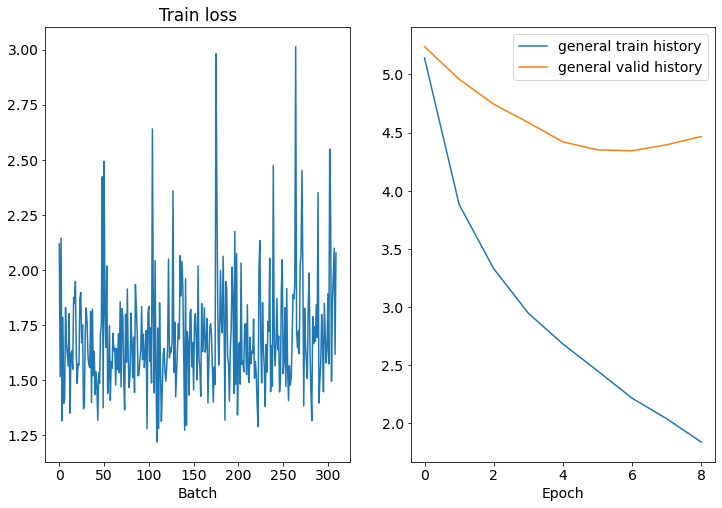

Epoch: 10 | Time: 3m 26s
	Train Loss: 1.695 | Train PPL:   5.448
	 Val. Loss: 4.447 |  Val. PPL:  85.384
CPU times: user 31min 35s, sys: 3min 2s, total: 34min 37s
Wall time: 34min 33s


In [ ]:
%%time
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
   
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_best.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model_save = model

In [ ]:
model_state  = torch.load("/content/drive/MyDrive/MADE/semester2/NLP/lab2/models_attention/model_best_ppl_85.384.pt")
#model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
model.load_state_dict(model_state)

<All keys matched successfully>

# Оцениваем результаты

In [ ]:
%%time
BATCH_SIZE_test = 32


train_iterator1, valid_iterator1, test_iterator1 = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE_test, 
    device = device,
    sort_key=_len_sort_key
)

test_loss = evaluate(model, test_iterator1, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.345 | Test PPL:  77.109 |
CPU times: user 8.36 s, sys: 455 ms, total: 8.82 s
Wall time: 8.8 s


In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm



In [ ]:
(original_text, generated_text) = generate_translation(model, test_iterator, TRG.vocab)

59it [00:08,  7.36it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

28.187610012318785

In [ ]:
for i, (orig_txt, gen_txt) in enumerate(zip(original_text, generated_text)):
  if i > 150:
    break
  print(" ".join(orig_txt))
  print(" ".join(gen_txt))
  print("\n")

вы сможете взять напрокат велосипеды .
желающие могут взять напрокат велосипед .


на вилле обустроена бесплатная парковка .
на территории обустроена бесплатная парковка .


на территории обустроена бесплатная парковка .
на территории обустроена бесплатная парковка .


в стоимость проживания включен континентальный завтрак .
в стоимость проживания входит континентальный завтрак .


сервируется завтрак " шведский стол ".
завтрак « шведский стол » сервируется завтрак « шведский стол ».


гостям предоставляется бесплатная парковка .
на территории обустроена бесплатная парковка .


услуги горничной предоставляются ежедневно .
ежедневно предоставляются услуги горничной .


также в распоряжении гостей камера хранения багажа .
в распоряжении гостей камера хранения багажа .


все номера оборудованы кондиционером .
все номера оснащены кондиционером . кондиционером .


из окон открывается вид на сад .
из окон открывается вид на сад .


в большинстве номеров обустроена гостиная зона .
в гостиной 

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

In [ ]:
(original_text_train, generated_text_train) = generate_translation(model, train_iterator, TRG.vocab)

313it [01:24,  3.72it/s]


In [ ]:
for i, (orig_txt, gen_txt) in enumerate(zip(original_text_train, generated_text_train)):
  if i > 150:
    break
  print(" ".join(orig_txt))
  print(" ".join(gen_txt))
  print("\n")

в радиусе 300 метров от мини - гостиницы работает несколько ресторанов .
в радиусе 300 метров от апартаментов работает множество ресторанов .


отель inn расположен у в город , в 200 метрах от торгового центра novo и в 5 минутах езды от аэропорта .
отель inn расположен в районе , в 200 метрах от торгового центра торгового центра и в 5 минутах езды от аэропорта суварнабхуми .


на территории обустроена бесплатная парковка .
на территории обустроена бесплатная парковка .


к вашим услугам гостиная с двуспальным диваном - кроватью , кухня открытой планировки и ванная комната .
в апартаментах есть гостиная с диваном - кроватью и спальня с кухня с кухня и кухня .


они расположены в 3 , 9 км от центрального бразилии и в 4 , 5 км от стадиона имени .
расстояние до центра центра составляет 3 , 9 км , а до — 4 , 5 км .


в каждом номере в вашем распоряжении холодильник , телевизор со спутниковыми каналами и собственная ванная комната с феном и душем или ванной .
в каждом номере есть холодильник

In [ ]:
corpus_bleu([[text] for text in original_text_train], generated_text_train) * 100

33.06309141805041

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.save({'model_state_dict': model_save.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
           },
            os.path.join("/content/drive/MyDrive/MADE/semester2/NLP/lab2/", f"lab2_attention_bleu28.0.tgz")
           )       

# Выводы

**Получили следующие показатели для модели**
```
**Train Loss: 1.695 | Train PPL:   5.448 | Train Bleu 33.06**

**Test Loss: 4.344 | Test PPL:  77.043 | Test Bleu 28.187**
```
**Удачные переводы:**

услуги горничной предоставляются ежедневно .   
ежедневно предоставляются услуги горничной .

**Радуют вот такие переводы:**

на территории гостевого дома есть открытый бассейн .  
гости могут плавать в открытом бассейне.

в числе удобств — терраса и бесплатная частная парковка .  
к услугам гостей бесплатная частная парковка .

**Неудачные переводы:**  
в числе удобств — собственная ванная комната .  
в собственной ванной комнате установлен собственная ванная комната .

производится доставка еды и напитков в номер .  
производится обслуживание номеров производится обслуживание номеров .

**Cкорость обучения модели:**  
(число эпох * число обработанных батчей за одну эпоху * размер батча):
10 * 40000 (~312 батчей по 128) 

**Время:**
```
Epoch: 10 | Time: 3m 26s
	Train Loss: 1.695 | Train PPL:   5.448
	 Val. Loss: 4.447 |  Val. PPL:  85.384
CPU times: user 31min 35s, sys: 3min 2s, total: 34min 37s
Wall time: 34min 33s
```
**Оцените степень переобучения модели**  
На трейне loss намного ниже, чем на валидейшене или тесте 1.6 против 4.3-4.4.Переобучение есть, но берем то значение весов, когда loss на валидейшене минимальное (до начала переобучения)

**Оцените скорость применения модели в режиме inference**  
в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)

Для батчей размером 32:
CPU times: user 8.36 s, sys: 455 ms, total: 8.82 s
Wall time: 8.8 s

**Были проведены следующие подэксперименты по fine-tuning сетки**

*   **Изменяла процент подачи в LSTM-блок новых слов, полученных из предыдущих блоков и слов из предложения (teacher_forcing) - при этом при увеличении количества слов, поданных "извне"  - сеть давала лучшие результаты на тренировочных данных и худшие на валидации (то есть лучше подстраивалась под train тексты и обучалась на них).**

*  **Менялись такие параметры как размер скытого слоя, размер embedding.**
*  **Здесь, как и в других моделях, очень важным оказалась инициализация весов. Небольшой начальный разброс значений обеспечиваает лучшую сходимость, чем если просто проинициализировать их одинаково нулями. Это дает разное значение градиента в разных параметрах**

